# Import

In [6]:
from datasets import load_dataset
from matplotlib import pyplot as plt
import torch
import transformers
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from peft import LoraConfig
from trl import SFTTrainer
from transformers import LlamaTokenizer


# Dataset

In [7]:
dataset_name = "databricks/databricks-dolly-15k"
dolly_15k = load_dataset(dataset_name)
print(dolly_15k)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})


# EDA on dataset

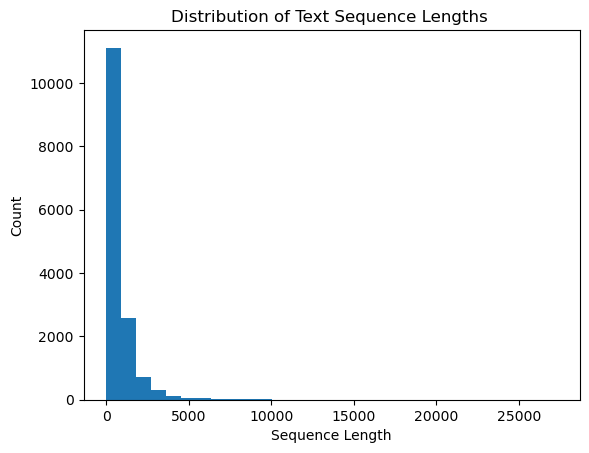

[9, 10, 25, 40, 59, 73, 76, 96, 145, 175]


In [8]:
def plot_sequence_len(ds, title = ''):
    too_long_idx = []
    seq_len = []

    for idx, example in enumerate(ds):
        length = len(example['instruction']) \
            + len(example['context']) \
            + len(example['response'])
        seq_len.append(length)

        if seq_len[idx]  > 2200:
            too_long_idx.append(idx)
    
    plt.hist(seq_len, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths ' + title)
    plt.show()

    return too_long_idx

too_long_idx = plot_sequence_len(dolly_15k['train'])

#filter out too long idx

print(too_long_idx[:10])

In [9]:
total_len = len(dolly_15k['train'])
print('total len = ', total_len)

total len =  15011


In [10]:
dolly_15k_reduced = dolly_15k['train'].select(
        i for i in range(total_len) 
        if i not in set(too_long_idx)
    )

#split train and test
dolly_15k_reduced = dolly_15k_reduced.train_test_split(test_size = 0.1)
print(dolly_15k_reduced)

Parameter 'indices'=<generator object <genexpr> at 0x78b97d8cb760> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})


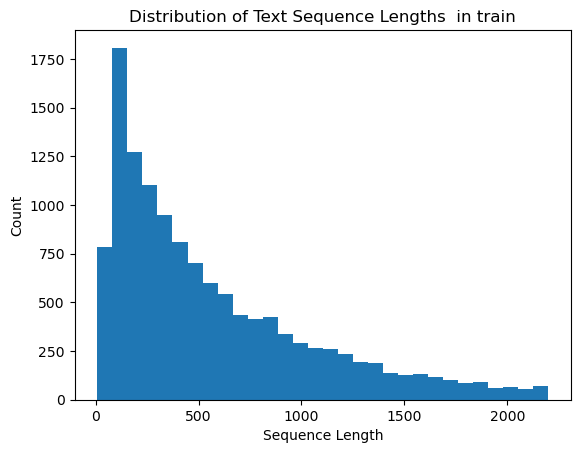

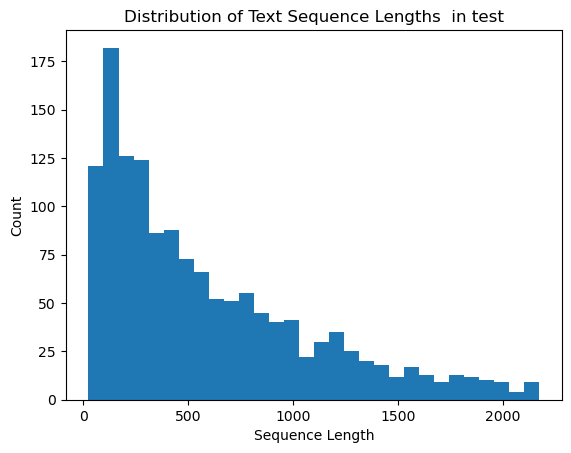

[]

In [11]:
plot_sequence_len(dolly_15k_reduced['train'], " in train")
plot_sequence_len(dolly_15k_reduced['test'], " in test")

In [12]:
a = ( "something" 
    "another"
    "weird"
)

print(a)
print(type(a))

somethinganotherweird
<class 'str'>


In [13]:
def format_func(example):
    #PEFT format
    if example.get("context", "") != "":
        #if this sample has context, use context as input, 
        input_prompt = (
            f"Below is an instruction that describes a task, paired with an input that provides further context. " 
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n"
            f"{example['instruction']}\n\n"
            f"### Input: \n"
            f"{example['context']}\n\n"
            f"### Response: \n"
            f"{example['response']}"
        )
    else:
        #default prompt
        input_prompt = (f"Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n"
            f"{example['instruction']}\n\n"
            f"### Response:\n"
            f"{example['response']}"
        )
    return {'text' : input_prompt}


formatted_dataset = dolly_15k_reduced.map(format_func)

#check after formatting
for example in formatted_dataset['train']:
    print(example)
    break

print(formatted_dataset)


Map: 100%|██████████| 1408/1408 [00:00<00:00, 26706.25 examples/s]

{'instruction': 'Which of the following are prime numbers: 7, 12, 23, 33, 64, 79, 97, and 100.', 'context': '', 'response': 'The numbers 7, 23, 79, and 97 are prime numbers.  The numbers 12, 33, 64, and 100 are not.', 'category': 'classification', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhich of the following are prime numbers: 7, 12, 23, 33, 64, 79, 97, and 100.\n\n### Response:\nThe numbers 7, 23, 79, and 97 are prime numbers.  The numbers 12, 33, 64, and 100 are not.'}
DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1408
    })
})


# Setup QLoRA (read the paper) and Quantization config

In [24]:
# model_id = "openlm-research/open_llama_7b"
# model_id = "meta-llama/Meta-Llama-3-8B"

# qlora_config = LoraConfig(
#     r = 16, #rank
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias="None",
#     task_type="CASUAL_LM",
# )

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# base_model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     quantization_config = bnb_config
# )

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


In [27]:
model_id = "openlm-research/open_llama_7b"

peft_config = LoraConfig(
    r = 16,
    lora_alpha=32, 
    lora_dropout=0.05,
    bias='None',
    task_type = 'CASUAL_LM'  
)

base_model = AutoModelForCausalLM.from_pretrained(model_id, load_in_8bit=True, device_map = 'auto')

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/home/nguyen/anaconda3/envs/torch/lib/python3.12/site-packages/accelerate/utils/modeling.py:1384: UserWarning: Current model requires 2048 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

# Tokenzier

# SFTTrainer